<a href="https://www.kaggle.com/code/naveenapaleti/natural-language-processing-with-disaster-tweets?scriptVersionId=165536581" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Step 1: Importing Necessary Libraries

In [1]:
import pandas as pd  # For data manipulation
from sklearn.feature_extraction.text import TfidfVectorizer  # For text vectorization
from sklearn.impute import SimpleImputer  # For handling missing values
from sklearn.preprocessing import LabelEncoder, StandardScaler  # For preprocessing
from sklearn.pipeline import Pipeline  # For creating a pipeline of preprocessing steps
from sklearn.compose import ColumnTransformer  # For applying different preprocessing to different columns
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning
from sklearn.linear_model import LogisticRegression  # For building the logistic regression model
from sklearn.metrics import f1_score  # For model evaluation

## Step 2: Loading and Understanding Data

In [2]:
# Load the training and test datasets
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
train_df.shape

(7613, 5)

In [6]:
# Display column types of train_df
train_df.dtypes

id           int64
keyword     object
location    object
text        object
target       int64
dtype: object

## Step 3: Data Cleaning

In [7]:
# Remove duplicate rows from the training dataset
train_df.drop_duplicates(inplace=True)

In [8]:
train_df.shape

(7613, 5)

In [9]:
# Fill missing values in both datasets with empty strings
train_df.fillna('', inplace=True)
test_df.fillna('', inplace=True)

#### Data Processing

In [10]:
# Text vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_text = vectorizer.fit_transform(train_df['text'])
X_test_text = vectorizer.transform(test_df['text'])

In [11]:
# Encoding categorical variables
label_encoder = LabelEncoder()
train_df['keyword'] = label_encoder.fit_transform(train_df['keyword'])
test_df['keyword'] = label_encoder.transform(test_df['keyword'])

## Step 4: Preprocessing Pipeline

In [12]:
# Define a pipeline for preprocessing text features
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=5000))  # TF-IDF vectorization
])

In [13]:
# Define a pipeline for preprocessing numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values with the mean
    ('scaler', StandardScaler())  # Standardize numerical features
])

In [14]:
# Define a column transformer to apply different preprocessing to different columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'text'),  # Apply text preprocessing to the 'text' column
    ('numerical', numerical_pipeline, ['keyword'])  # Apply numerical preprocessing to the 'keyword' column
])

## Step 5: Model Building

In [15]:
# Define the logistic regression model with preprocessing pipeline
logistic_regression = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess features
    ('classifier', LogisticRegression())  # Build logistic regression classifier
])

## Step 6: Hyperparameter Tuning

In [16]:
# Define the grid of hyperparameters to search
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]  # Regularization parameter values
}

In [17]:
# Perform grid search with 5-fold cross-validation to find the best hyperparameters
grid_search = GridSearchCV(logistic_regression, param_grid, cv=5, scoring='f1')
grid_search.fit(train_df[['text', 'keyword']], train_df['target'])

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('text',
                                                                         Pipeline(steps=[('tfidf',
                                                                                          TfidfVectorizer(max_features=5000,
                                                                                                          stop_words='english'))]),
                                                                         'text'),
                                                                        ('numerical',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['keyword'])])),
                                       ('classifier', LogisticRegression())]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
             scoring='f1')

## Step 7: Model Evaluation

In [18]:
# Get the best model from the grid search
best_model = grid_search.best_estimator_

In [19]:
# Make predictions on the training data for evaluation
y_val_pred = best_model.predict(train_df[['text', 'keyword']])

In [20]:
# Calculate F1 score to evaluate the model
f1 = f1_score(train_df['target'], y_val_pred)
print("F1 Score on Training Data:", f1)

F1 Score on Training Data: 0.8297658862876254


### Extra Feature Engineering



In [21]:
# Length of tweet
train_df['tweet_length'] = train_df['text'].apply(lambda x: len(x))
test_df['tweet_length'] = test_df['text'].apply(lambda x: len(x))

In [22]:
# Number of words in tweet
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))

### Visualizations

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

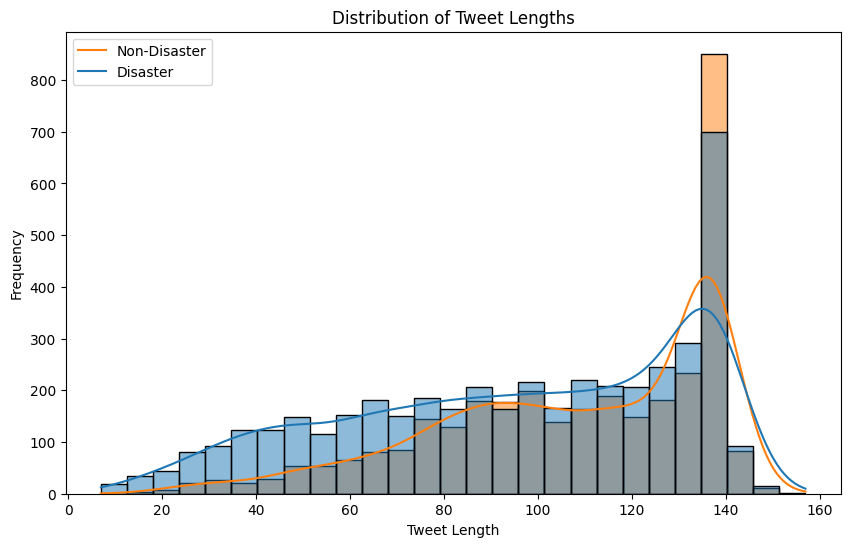

In [24]:
# Distribution of tweet lengths for disaster and non-disaster tweets
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='tweet_length', hue='target', kde=True)
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.legend(['Non-Disaster', 'Disaster'])
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

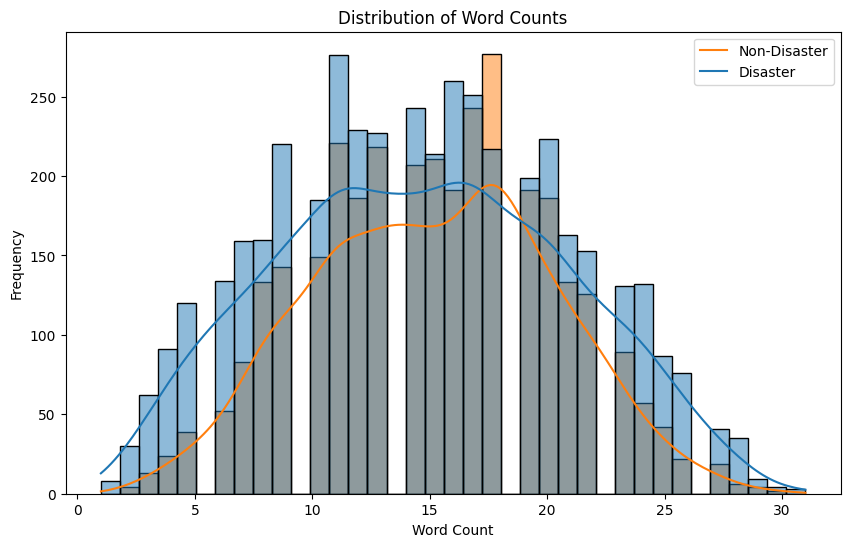

In [25]:
# Distribution of word counts for disaster and non-disaster tweets
plt.figure(figsize=(10, 6))
sns.histplot(data=train_df, x='word_count', hue='target', kde=True)
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.legend(['Non-Disaster', 'Disaster'])
plt.show()

## Step 8: Model Evaluation

In [26]:
from sklearn.metrics import classification_report, confusion_matrix

In [27]:
# Classification Report
print(classification_report(train_df['target'], y_val_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4342
           1       0.92      0.76      0.83      3271

    accuracy                           0.87      7613
   macro avg       0.88      0.85      0.86      7613
weighted avg       0.87      0.87      0.86      7613



In [28]:
# Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(train_df['target'], y_val_pred))

Confusion Matrix:
[[4114  228]
 [ 790 2481]]


## Step 9: Submission

In [29]:
# Make predictions on the test data for submission
y_test_pred = best_model.predict(test_df[['text', 'keyword']])

In [30]:
# Create a submission dataframe
submission_df = pd.DataFrame({'id': test_df['id'], 'target': y_test_pred})

In [31]:
# Save the submission dataframe to a CSV file
submission_df.to_csv('submission.csv', index=False)